# Временные ряды


# Декомпозиция временного ряда

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=DOM_hourly.csv

In [15]:
df = pd.read_csv('DOM_hourly.csv', sep =',', parse_dates=['Datetime'], index_col='Datetime')
df = df.rename(columns={"DOM_MW": "MW"})
df.sort_index(inplace=True)
len(df)

116189

In [16]:
df1 = df.iloc[::24]
df1.head(10)

,MW
Datetime,
2005-05-01 01:00:00,7190.0
2005-05-02 01:00:00,6897.0
2005-05-03 01:00:00,7288.0
2005-05-04 01:00:00,7052.0
2005-05-05 01:00:00,7250.0
2005-05-06 01:00:00,7237.0
2005-05-07 01:00:00,7901.0
2005-05-08 01:00:00,6984.0
2005-05-09 01:00:00,6772.0


<Axes: title={'center': 'Потребление энергии'}, xlabel='Datetime'>

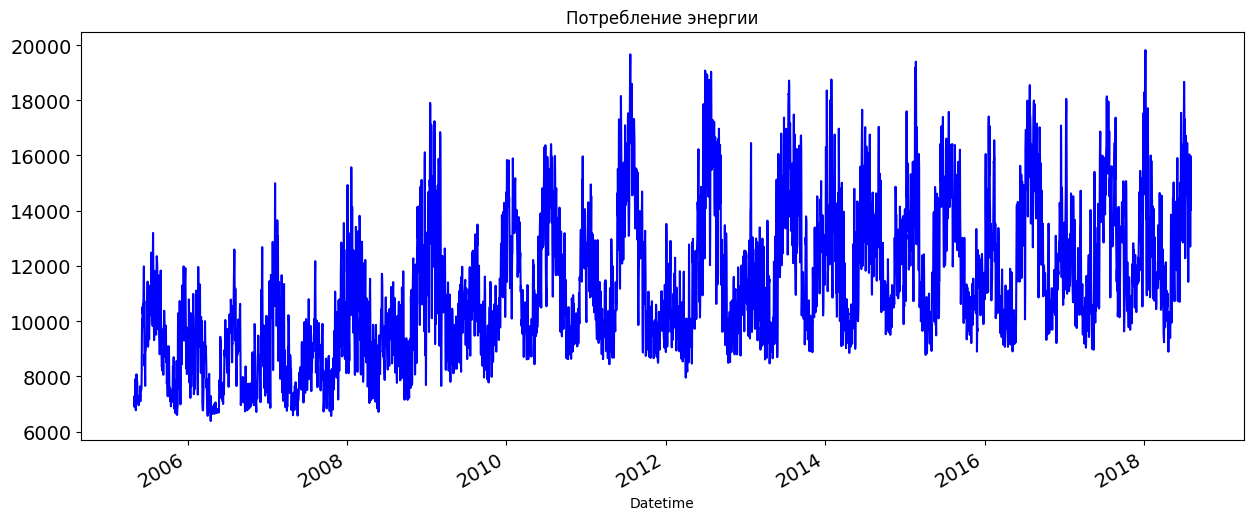

In [17]:
df1.MW.plot(figsize=(15,6),title= 'Потребление энергии', fontsize=14, color="blue")

### Сезонность

In [18]:
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df.head(5)

,MW,year,month,hour,dayofweek
Datetime,,,,,
2005-05-01 01:00:00,7190.0,2005,5,1,6
2005-05-01 02:00:00,6803.0,2005,5,2,6
2005-05-01 03:00:00,6583.0,2005,5,3,6
2005-05-01 04:00:00,6452.0,2005,5,4,6
2005-05-01 05:00:00,6445.0,2005,5,5,6


In [19]:
df_pivot = pd.pivot_table(df, values = "MW", columns = "year", index = "month")
df_pivot.head(5)

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,
1,NaN,10450.461022,11132.239247,11788.540323,12499.696237,12513.037634,12752.266129,11162.112903,11657.752688,13452.858871,12842.047043,12588.647849,11811.150538,13873.676075
2,NaN,10981.627976,12531.474702,11113.162356,11224.026786,12551.462798,11109.194940,10751.744253,11798.516369,12217.985119,14236.325893,11918.689655,10623.105655,11237.282738
3,NaN,9859.708333,10049.815612,9755.627187,10214.248991,9831.710633,10047.228802,9314.983849,11007.746972,11355.911171,11008.860027,9631.471063,10566.990579,11345.138627
4,NaN,8702.517385,9437.031944,9251.127778,9141.037500,8914.134722,9273.422222,8856.384722,9353.938889,9083.747222,9041.870833,9264.854167,9520.255556,9526.201389
5,8681.652759,9307.391129,9840.474462,9303.047043,9519.729839,10050.463710,9952.155914,10064.112903,9701.223118,9821.220430,10370.633065,9508.452957,9870.743280,10869.827957


<Axes: title={'center': 'Компоненты сезонности'}, xlabel='month'>

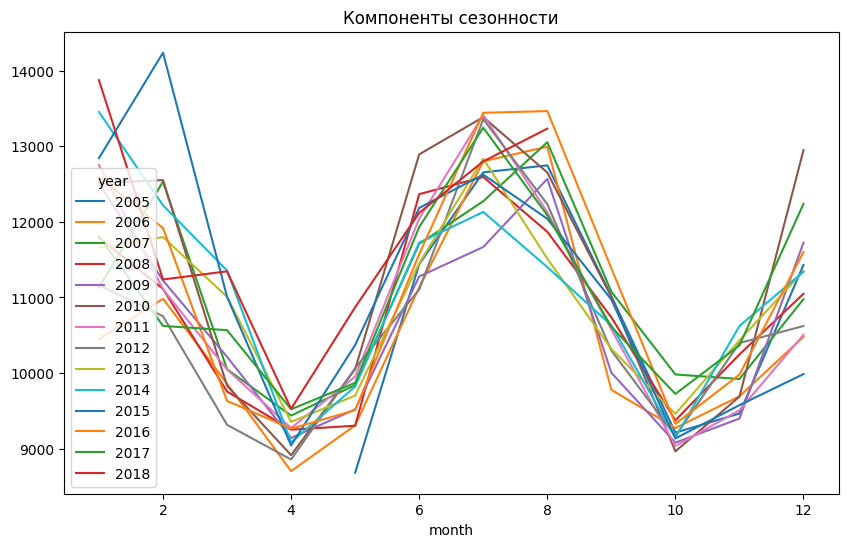

In [20]:
df_pivot.plot(figsize=(10, 6),title= 'Компоненты сезонности', fontsize=10)

### Автокорреляция

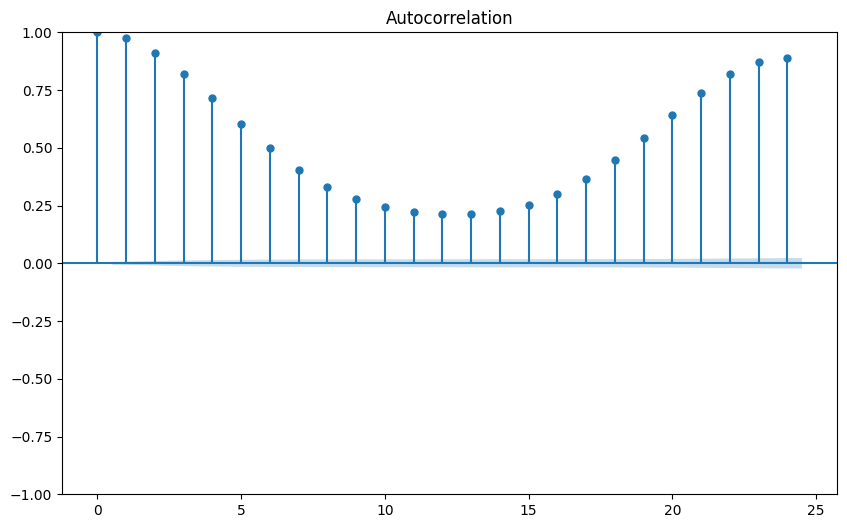

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(10,6))
plot_acf(df["MW"].values, lags=24, ax=ax);
plt.show()

### Тренд

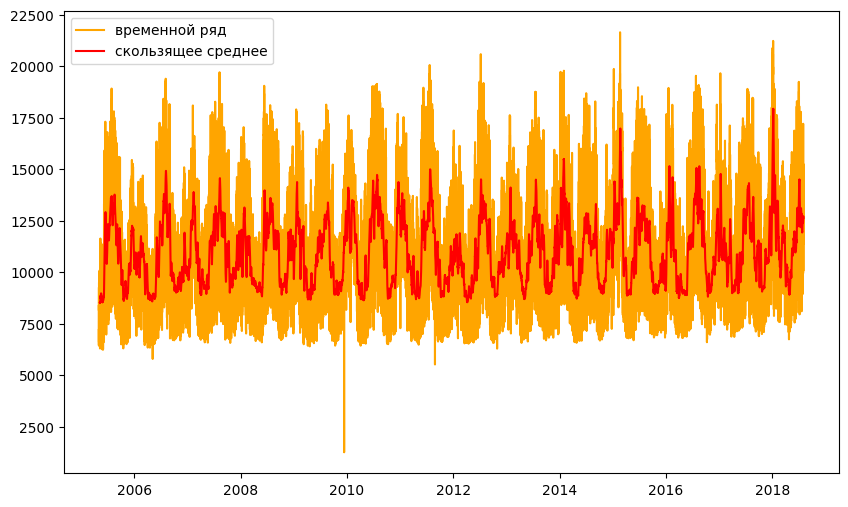

In [22]:
plt.figure(figsize=(10, 6))

rolling_mean = df.MW.rolling(window=24*7).mean()
plt.plot(df.index, df.MW, label='временной ряд', color="orange")
plt.plot(df.index, rolling_mean, label='скользящее среднее', color="red")
plt.legend(loc='best')
plt.show()

## Декомпозиция временного ряда через statsmodels

Text(0, 0.5, 'Остаток')

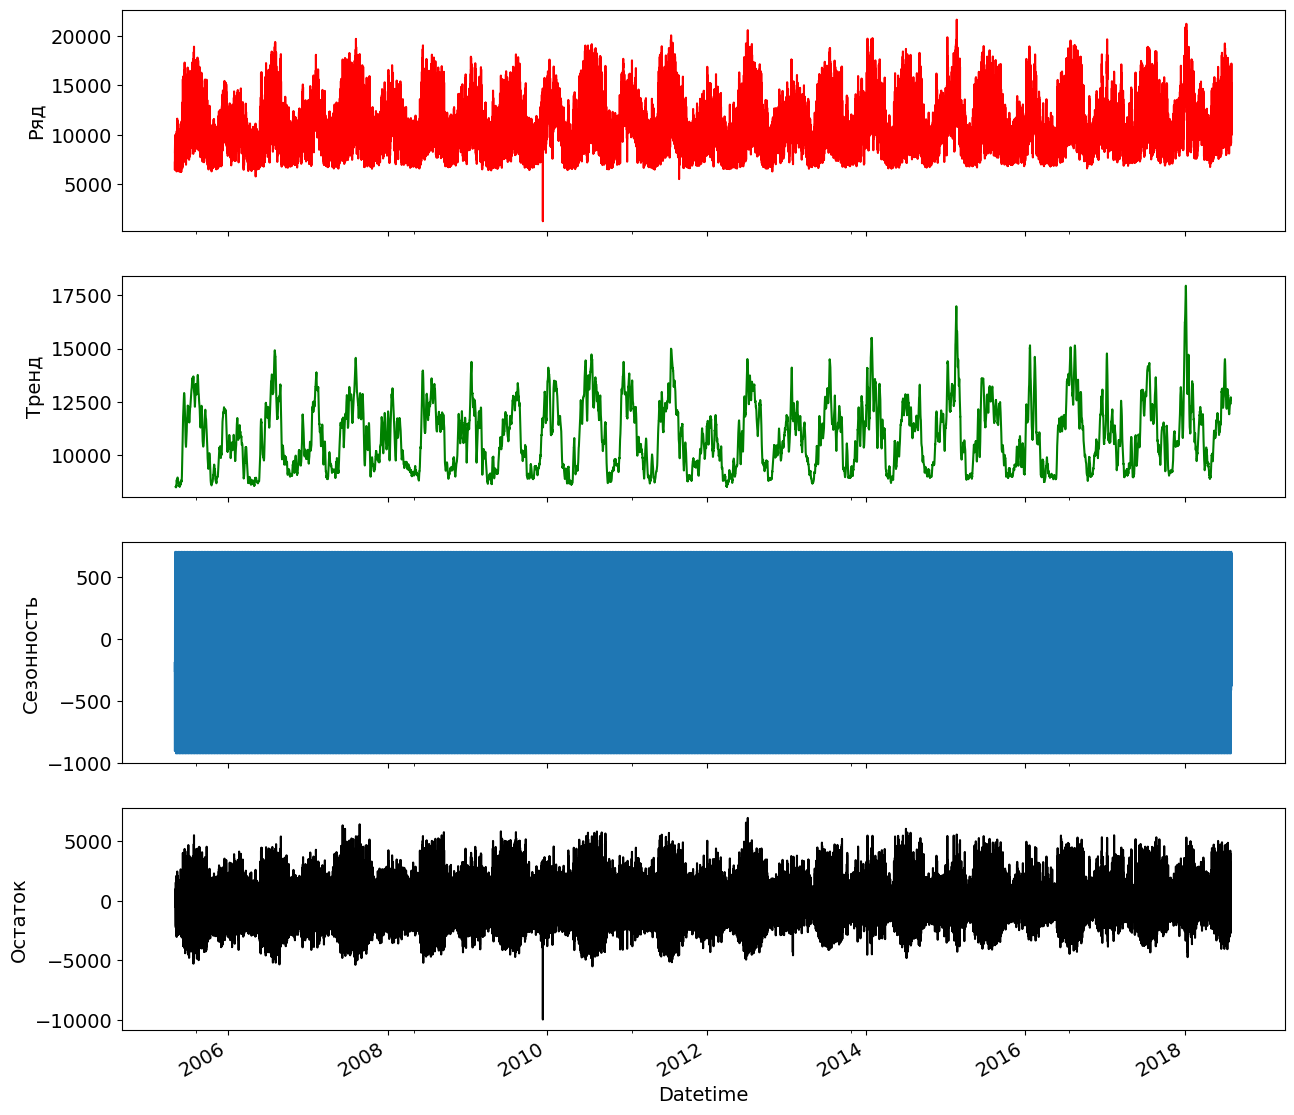

In [23]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (15, 15)

res = sm.tsa.seasonal_decompose(df.MW, model='additive', period= 24 * 7)
fig, axes = plt.subplots(4, 1, sharex=True)

res.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Ряд')
res.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Тренд')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Сезонность')
res.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Остаток')

<Axes: xlabel='resid', ylabel='Count'>

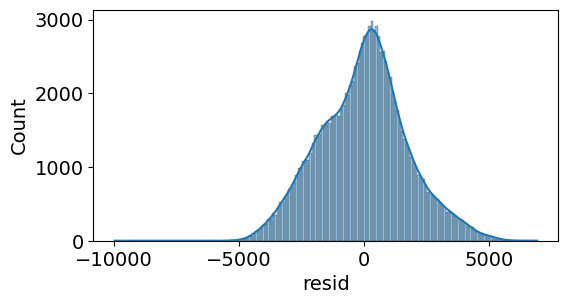

In [24]:
plt.figure(figsize=(6, 3)) # Остатки - результат удаления из исходного временного ряда компонент сезонности и тренда
sns.histplot(res.resid, kde='True')

# Прогнозирование временных рядов

Задача - предсказать потребление энергии на следующую неделю.

In [25]:
week = 24*7

train = df.iloc[-24*365:-week]
val   = df.iloc[-week:] # последние 24 часа

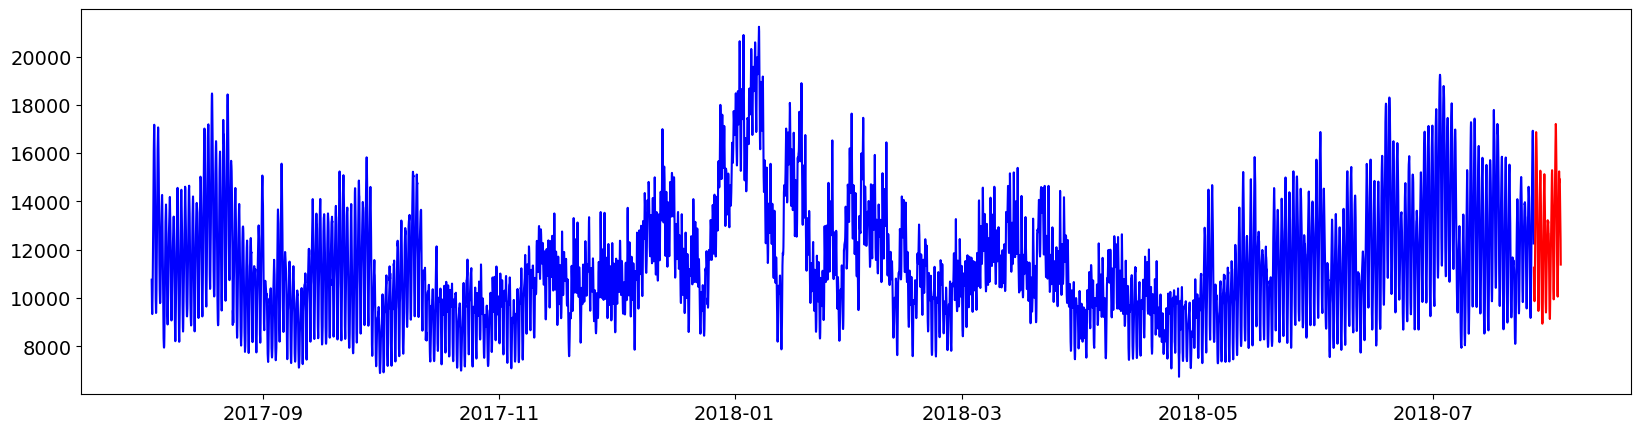

In [26]:
plt.figure(figsize=(20, 5))

plt.plot(train.MW, color="blue")
plt.plot(val.MW, color="red")

plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

preds = [train.MW.mean()] * week # Наивный метод 1

print('RMSE =', sqrt(mean_squared_error(val.MW, preds)))
print('MAPE =', mean_absolute_percentage_error(val.MW, preds))

RMSE = 2529.1379160633182
MAPE = 0.15831204634092777


In [29]:
preds = train.iloc[-week:].MW.values # Наивный метод 2

print('RMSE =', sqrt(mean_squared_error(val.MW, preds)))
print('MAPE =', mean_absolute_percentage_error(val.MW, preds))

RMSE = 1344.4058299911844
MAPE = 0.0831065816799391


In [30]:
n = 10
W = np.array([0.001, 0.002, 0.003, 0.004, 0.05, 0.07, 0.1, 0.16, 0.25, 0.36]) # Взвешенное среднее

train_weeks = train.iloc[-n*week:]
train_weeks = np.array(train_weeks.MW).reshape(n,-1)

preds_arr_W = np.array([train_weeks[x]*W[x] for x in range(len(W))])
preds = preds_arr_W.sum(axis = 0)

sum(W)

np.float64(1.0)

In [31]:
print('RMSE =', sqrt(mean_squared_error(val.MW, preds)))
print('MAPE =', mean_absolute_percentage_error(val.MW, preds))

RMSE = 1049.6299208354997
MAPE = 0.06311646386089857


## Экспоненциальное сглаживание

In [45]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train.MW), seasonal_periods=24, trend='add', seasonal='add').fit()
forecast = pd.Series(fit1.forecast(len(val)))
forecast.index = val.index

In [33]:
print('RMSE =', sqrt(mean_squared_error(val.MW, preds)))
print('MAPE =', mean_absolute_percentage_error(val.MW, preds))

RMSE = 1049.6299208354997
MAPE = 0.06311646386089857


## Кросс-валидация

In [34]:
from sklearn.model_selection import TimeSeriesSplit
errors = []

tscv = TimeSeriesSplit(n_splits=4)

for train_idx, test_idx in tscv.split(df.MW):
    print('len_train =', len(train_idx))
    print('len_test =', len(test_idx))

    # Задаём модель
    model = ExponentialSmoothing(np.asarray(df.MW.iloc[train_idx]), seasonal_periods=24, seasonal='add').fit()

    # Делаем предсказание
    forecast = pd.Series(model.forecast(len(test_idx)))

    # Считаем ошибку
    actual = df.MW.iloc[test_idx]
    error = sqrt(mean_squared_error(actual.values, forecast.values))
    errors.append(error)

len_train = 23241
len_test = 23237
len_train = 46478
len_test = 23237
len_train = 69715
len_test = 23237
len_train = 92952
len_test = 23237


In [35]:
errors

[2889.7389849968517, 3121.3546263435833, 4509.177338970529, 2410.0486857698006]

In [36]:
np.mean(errors)

np.float64(3232.579909020191)

# ARIMA

order = (p, d, q)

p - порядок модели авторегрессии (то есть максимальный лаг)

d - параметр дифференцирования временного ряда

q - длина окна сглаживания

In [53]:
from statsmodels.tsa.arima.model import ARIMA

mod = sm.tsa.arima.ARIMA(val.MW, order=(7,0,2))
res = mod.fit()

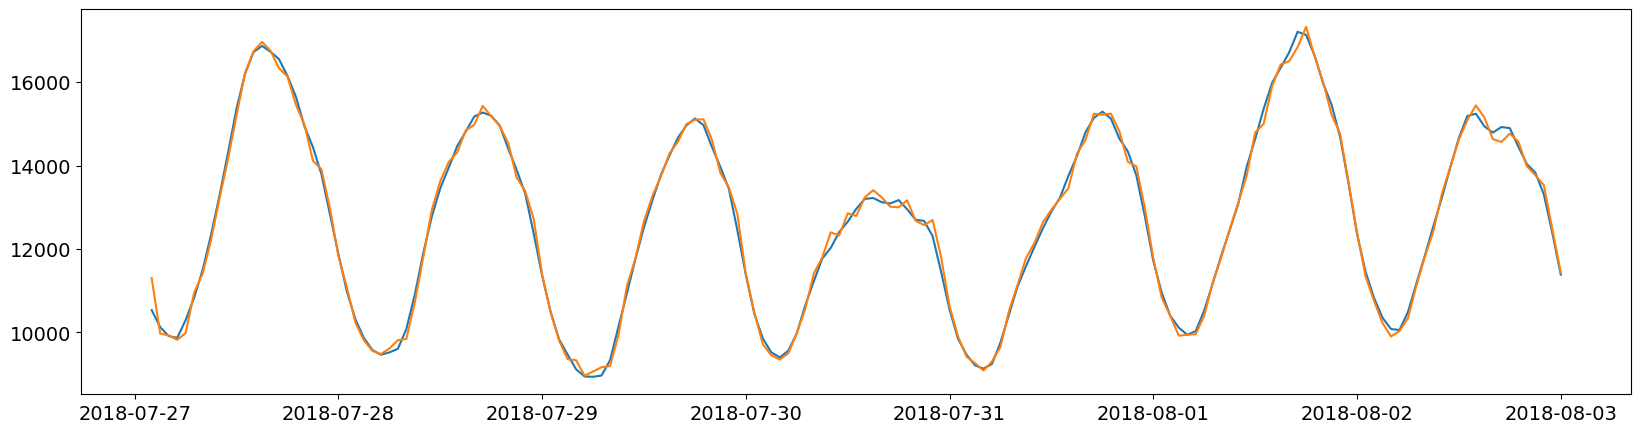

In [54]:
plt.figure(figsize=(20, 5))

preds = res.predict(dynamic=False)
plt.plot(val.MW[1:])
plt.plot(preds[1:])

In [50]:
print('RMSE =', sqrt(mean_squared_error(val.MW, preds)))

RMSE = 1041.1887065364508


In [52]:
import itertools
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_rmse = np.inf

for params in tqdm(pdq):
  model_test = sm.tsa.arima.ARIMA(val.MW, order = params)
  result_test = model_test.fit()
  preds = result_test.predict(dynamic=False)

  rmse_ = sqrt(mean_squared_error(val.MW, preds))
  if rmse_ < best_rmse:
    best_params = params
    best_rmse = rmse_
print(best_params, best_rmse)

  0%|          | 0/90 [00:00<?, ?it/s]

(7, 0, 2) 190.3931007874696
